In [1]:
import torch
import torch.nn as nn
import torch.optim as optim


In [2]:
config1 = [
    (32, 3, 1),  #filters, kernel_size, stride
    (64, 3, 2),
    ["B", 1],       #residual ["B",pocet opakovani]
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    # first route from the end of the previous block
    (512, 3, 2),
    ["B", 8],
    # second route from the end of the previous block
    (1024, 3, 2),
    ["B", 4],
    # Yolo
    (512, 1, 1),
    (1024, 3, 1),
    "S",            #scale prediction, na rozdiel od pepera nemame 4 vrstvy, iba 2,13x13
    (256, 1, 1),
    "U",            #upsample 26x26
    (256, 1, 1),
    (512, 3, 1),
    "S",            #scale prediction
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]

In [3]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act

    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super(ResidualBlock, self).__init__()
        self.layers = nn.ModuleList()
        for repeat in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlock(channels, channels // 2, kernel_size=1),
                    CNNBlock(channels // 2, channels, kernel_size=3, padding=1),
                )
            ]

        self.use_residual = use_residual
        self.num_repeats = num_repeats

    def forward(self, x):
        for layer in self.layers:
            x = layer(x) + self.use_residual * x

        return x

In [5]:
class ScalePrediction(nn.Module):
    def __init__(self, in_channels, num_classes): #anchors_per_scale
        super(ScalePrediction, self).__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2*in_channels, kernel_size=3, padding=1),
            CNNBlock(2*in_channels, (num_classes + 5) * 3, bn_act=False, kernel_size=1),
        )
        self.num_classes = num_classes
        self.anchors_per_scale = 3 #anchors_per_scale

    def forward(self, x):
        return (
            self.pred(x)
                .reshape(x.shape[0], self.anchors_per_scale, self.num_classes + 5, x.shape[2], x.shape[3])
                .permute(0, 1, 3, 4, 2)
        )

In [6]:
print(config1)

[(32, 3, 1), (64, 3, 2), ['B', 1], (128, 3, 2), ['B', 2], (256, 3, 2), ['B', 8], (512, 3, 2), ['B', 8], (1024, 3, 2), ['B', 4], (512, 1, 1), (1024, 3, 1), 'S', (256, 1, 1), 'U', (256, 1, 1), (512, 3, 1), 'S', (128, 1, 1), 'U', (128, 1, 1), (256, 3, 1), 'S']


In [7]:
class YOLOv3(nn.Module):
    def __init__(self, in_channels=3, num_classes=4):
        super(YOLOv3, self).__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()

    def forward(self, x):
        outputs = []
        route_connections = []
        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue

            x = layer(x)
            print(x.shape) #for testing purposes

            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)

            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()

        return outputs


    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels

        for module in config1:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0,
                    )
                )
                in_channels = out_channels

            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(
                    ResidualBlock(
                        in_channels,
                        num_repeats=num_repeats,
                    )
                )

            elif isinstance(module, str):
                if module == "S":
                    layers += [
                        ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                        CNNBlock(in_channels, in_channels // 2, kernel_size=1),
                        ScalePrediction(in_channels // 2, num_classes=self.num_classes)
                    ]
                    in_channels = in_channels // 2

                elif module == "U":
                    layers.append(
                        nn.Upsample(scale_factor=2),
                    )
                    in_channels = in_channels * 3

        return layers

In [8]:
def test():
    num_classes = 4#20
    img_size = 416
    model = YOLOv3(num_classes=num_classes)

    x = torch.randn((2, 3, img_size, img_size))
    out = model(x)
    assert out[0].shape == (2, 3, img_size//32, img_size//32, 5 + num_classes)
    assert out[1].shape == (2, 3, img_size//16, img_size//16, 5 + num_classes)
    assert out[2].shape == (2, 3, img_size//8, img_size//8, 5 + num_classes)
    print(out[0].shape)

test()

torch.Size([2, 32, 416, 416])
torch.Size([2, 64, 208, 208])
torch.Size([2, 64, 208, 208])
torch.Size([2, 128, 104, 104])
torch.Size([2, 128, 104, 104])
torch.Size([2, 256, 52, 52])
torch.Size([2, 256, 52, 52])
torch.Size([2, 512, 26, 26])
torch.Size([2, 512, 26, 26])
torch.Size([2, 1024, 13, 13])
torch.Size([2, 1024, 13, 13])
torch.Size([2, 512, 13, 13])
torch.Size([2, 1024, 13, 13])
torch.Size([2, 1024, 13, 13])
torch.Size([2, 512, 13, 13])
torch.Size([2, 256, 13, 13])
torch.Size([2, 256, 26, 26])
torch.Size([2, 256, 26, 26])
torch.Size([2, 512, 26, 26])
torch.Size([2, 512, 26, 26])
torch.Size([2, 256, 26, 26])
torch.Size([2, 128, 26, 26])
torch.Size([2, 128, 52, 52])
torch.Size([2, 128, 52, 52])
torch.Size([2, 256, 52, 52])
torch.Size([2, 256, 52, 52])
torch.Size([2, 128, 52, 52])
torch.Size([2, 3, 13, 13, 9])


# Loss

In [9]:
"""
Implementation of Yolo Loss Function similar to the one in Yolov3 paper,
the difference from what I can tell is I use CrossEntropy for the classes
instead of BinaryCrossEntropy.
"""
import random
import torch
import torch.nn as nn
import utils


class YoloLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # Constants
        self.lambda_class = 1
        self.lambda_noobj = 1
        self.lambda_obj = 1
        self.lambda_box = 1

        self.mse = nn.MSELoss()             #for box predictions
        self.bce = nn.BCEWithLogitsLoss()
        self.entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()


    def forward(self, predictions, target, anchors):
        obj = target[..., 0] == 1
        noobj = target[..., 0] == 0

        no_object_loss = self.bce((predictions[..., 0:1][noobj]), (target[..., 0:1][noobj]),)

        anchors = anchors.reshape(1, 3, 1, 1, 2)# Reschape anchors to allow for broadcasting in multiplication below
        # Convert outputs from model to bounding boxes according to formulas in paper
        box_preds = torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
        ious = utils.intersection_over_union(box_preds[obj], target[..., 1:5][obj]).detach()
        object_loss = self.bce((predictions[..., 0:1][obj]), (ious * target[..., 0:1][obj]))

        predictions[..., 1:3] = self.sigmoid(predictions[..., 1:3])
        # to improve gradient flow we convert targets' width and height to the same format as predictions
        target[..., 3:5] = torch.log((1e-16 + target[..., 3:5] / anchors))
        box_loss = self.mse(predictions[..., 1:5][obj], target[..., 1:5][obj])#mse for boxes

        class_loss = self.entropy((predictions[..., 5:][obj]), (target[..., 5][obj].long()),)

        return (
            self.lambda_box * box_loss + self.lambda_obj * object_loss
            + self.lambda_noobj * no_object_loss + self.lambda_class * class_loss
        )


# Data

In [10]:
#import config
import numpy as np
import os
import pandas as pd
import torch

from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
from utils import (
    cells_to_bboxes, # only for testing
    iou_width_height as iou,
    non_max_suppression as nms, # only for testing
    plot_image #only for testing
)

ImageFile.LOAD_TRUNCATED_IMAGES = True # na errory pri loadovani img

In [11]:
import matplotlib.pyplot as plt

In [12]:
def check_bbox(bbox):
    """Check if bbox boundaries are in range 0, 1 and minimums are lesser then maximums"""
   #my added block 
    bbox=list(bbox)
    for i in range(4):
      if (bbox[i]<0) :
        bbox[i]=0
      elif (bbox[i]>1) :
        bbox[i]=1
    bbox=tuple(bbox)
   #end of block
   #rest of the code as it is

In [13]:
class YOLODataset(Dataset):
    def __init__(
        self,
        csv_file,
        img_dir,
        label_dir,
        anchors,
        image_size=416,
        S=[13, 26, 52],
        C=4,#20,
        transform=None,
    ):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.image_size = image_size
        self.transform = transform
        self.S = S
        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])  # for all 3 scales
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.C = C
        self.ignore_iou_thresh = 0.5

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1).tolist()
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = np.array(Image.open(img_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=image, bboxes=bboxes)
            image = augmentations["image"]
            bboxes = augmentations["bboxes"]

        # Below assumes 3 scale predictions (as paper) and same num of anchors per scale
        targets = [torch.zeros((self.num_anchors // 3, S, S, 6)) for S in self.S]
        for box in bboxes:
            iou_anchors = iou(torch.tensor(box[2:4]), self.anchors)
            anchor_indices = iou_anchors.argsort(descending=True, dim=0)
            x, y, width, height, class_label = box
            #print("YoloDataset x,y: ",x, y)
            has_anchor = [False] * 3  # each scale should have one anchor
            for anchor_idx in anchor_indices:
                scale_idx = anchor_idx // self.num_anchors_per_scale
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale
                S = self.S[scale_idx]
                i, j = int(S * y), int(S * x)  # which cell
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]
                if not anchor_taken and not has_anchor[scale_idx]:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1
                    x_cell, y_cell = S * x - j, S * y - i  # both between [0,1]
                    #print(x_cell, y_cell)
                    width_cell, height_cell = (
                        width * S,
                        height * S,
                    )  # can be greater than 1 since it's relative to cell
                    box_coordinates = torch.tensor(
                        [x_cell, y_cell, width_cell, height_cell]
                    )
                    check_bbox(box_coordinates)
                    #print([x_cell, y_cell, width_cell, height_cell])
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
                    has_anchor[scale_idx] = True

                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1  # ignore prediction
        #print(targets)
        return image, tuple(targets)


 :  Compose([
  LongestMaxSize(always_apply=False, p=1, max_size=416, interpolation=1),
  Normalize(always_apply=False, p=1.0, mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params={'format': 'yolo', 'label_fields': [], 'min_area': 0.0, 'min_visibility': 0.4, 'check_each_transform': True}, keypoint_params=None, additional_targets={})  : 
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([1, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([1, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([1, 3, 52, 52, 6])
Counter>  0
BOXES:  [[1.0, 1.0, 0.5323120355606079, 0.7606480121612549, 0.02472900040447712, 0.03874100372195244], [0.0, 1.0, 0.5636770129203796, 0.755046010017395, 0.0020310000982135534, 0.021647999063134193], [3.0, 1.0, 0.5685470104217529, 0.7060880064964294, 0.0040420000441372395, 0.0108800008893013], [3.0, 1.0, 0.5685470104217529, 0.7060

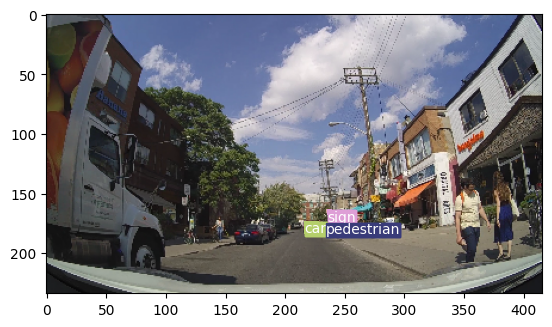

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([1, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([1, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([1, 3, 52, 52, 6])
Counter>  1
BOXES:  [[1.0, 1.0, 0.5310760140419006, 0.7603750228881836, 0.024599000811576843, 0.038287002593278885], [0.0, 1.0, 0.5613020062446594, 0.7543290257453918, 0.0016250000335276127, 0.02076900005340576], [3.0, 1.0, 0.5665990114212036, 0.7070690393447876, 0.0040420000441372395, 0.0108800008893013], [3.0, 1.0, 0.5665990114212036, 0.7070690393447876, 0.0040420000441372395, 0.0108800008893013], [1.0, 1.0, 0.5310760140419006, 0.7603750228881836, 0.024599000811576843, 0.038287002593278885], [0.0, 1.0, 0.5613020062446594, 0.7543290257453918, 0.0016250000335276127, 0.02076900005340576], [3.0, 1.0, 0.5665990114212036, 0.7070690393447876, 0.0040420000441372395, 0.0108800008893013], [1.0, 1.0, 0.5310760140419006, 0.7603750228881836, 0.024599000811576843, 0.0

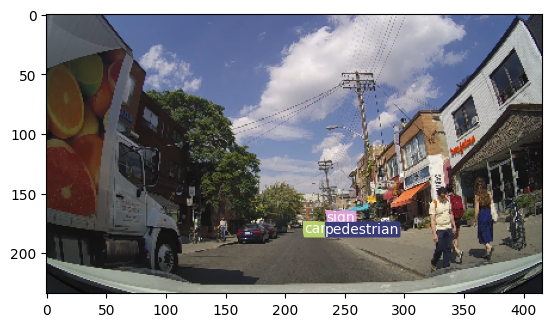

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([1, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([1, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([1, 3, 52, 52, 6])
Counter>  2
BOXES:  [[1.0, 1.0, 0.5307660102844238, 0.7603100538253784, 0.02456199936568737, 0.038176000118255615], [0.0, 1.0, 0.5607060194015503, 0.754148006439209, 0.0015259999781847, 0.020556000992655754], [3.0, 1.0, 0.5661150217056274, 0.7073190212249756, 0.0040420000441372395, 0.0108800008893013], [3.0, 1.0, 0.5661150217056274, 0.7073190212249756, 0.0040420000441372395, 0.0108800008893013], [1.0, 1.0, 0.5307660102844238, 0.7603100538253784, 0.02456199936568737, 0.038176000118255615], [0.0, 1.0, 0.5607060194015503, 0.754148006439209, 0.0015259999781847, 0.020556000992655754], [3.0, 1.0, 0.5661150217056274, 0.7073190212249756, 0.0040420000441372395, 0.0108800008893013], [1.0, 1.0, 0.5307660102844238, 0.7603100538253784, 0.02456199936568737, 0.0381760001

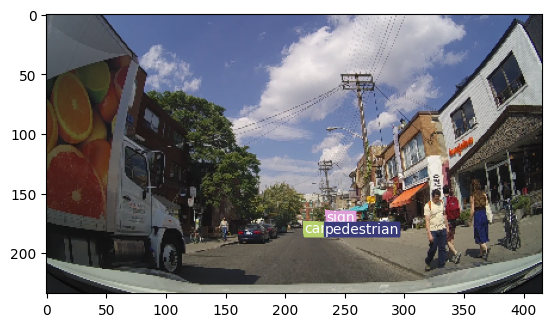

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([1, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([1, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([1, 3, 52, 52, 6])
Counter>  3
BOXES:  [[1.0, 1.0, 0.5347890257835388, 0.7611940503120422, 0.024984000250697136, 0.03964800387620926], [0.0, 1.0, 0.5674639940261841, 0.7547550201416016, 0.001990000018849969, 0.02323099970817566], [3.0, 1.0, 0.572286069393158, 0.7047920227050781, 0.0040420000441372395, 0.0108800008893013], [3.0, 1.0, 0.572286069393158, 0.7047920227050781, 0.0040420000441372395, 0.0108800008893013], [1.0, 1.0, 0.5347890257835388, 0.7611940503120422, 0.024984000250697136, 0.03964800387620926], [0.0, 1.0, 0.5674639940261841, 0.7547550201416016, 0.001990000018849969, 0.02323099970817566], [3.0, 1.0, 0.5722860097885132, 0.7047920227050781, 0.0040420000441372395, 0.0108800008893013], [1.0, 1.0, 0.5347890257835388, 0.7611940503120422, 0.024984000250697136, 0.0396480

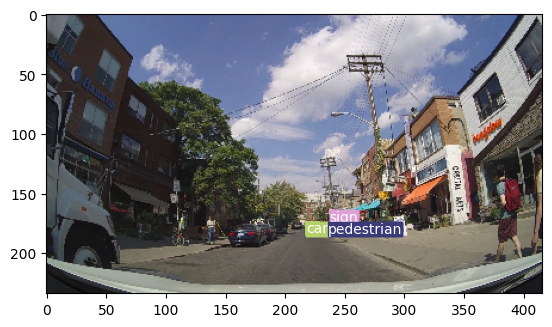

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([1, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([1, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([1, 3, 52, 52, 6])
Counter>  4
BOXES:  [[1.0, 1.0, 0.5316950082778931, 0.7605140209197998, 0.024661000818014145, 0.038509003818035126], [0.0, 1.0, 0.5624899864196777, 0.7546900510787964, 0.001823000144213438, 0.021213000640273094], [3.0, 1.0, 0.5675730109214783, 0.7065790295600891, 0.0040420000441372395, 0.0108800008893013], [3.0, 1.0, 0.5675730109214783, 0.7065790295600891, 0.0040420000441372395, 0.0108800008893013], [1.0, 1.0, 0.5316950082778931, 0.7605140209197998, 0.024661000818014145, 0.038509003818035126], [0.0, 1.0, 0.5624899864196777, 0.7546900510787964, 0.001823000144213438, 0.021213000640273094], [3.0, 1.0, 0.5675730109214783, 0.7065790295600891, 0.0040420000441372395, 0.0108800008893013], [1.0, 1.0, 0.5316950082778931, 0.7605140209197998, 0.024661000818014145, 0.0

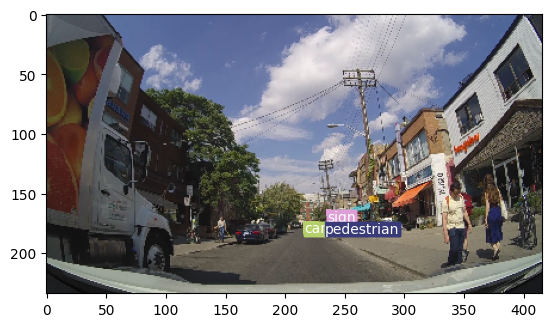

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([1, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([1, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([1, 3, 52, 52, 6])
Counter>  5


In [14]:
import config
from pprint import pprint
def test():
    anchors = config.ANCHORS

    transform = config.test_transforms

    dataset = YOLODataset(
        '../train.csv',
        config.IMG_DIR,
        config.LABEL_DIR,
        S=config.S,#[13, 26, 52],
        anchors=anchors,
        transform=transform,
    )
    print(" : ",dataset.transform," : ")
    S = config.S #[13, 26, 52]
    scaled_anchors = torch.tensor(anchors) / (
        1 / torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    )
    loader = DataLoader(dataset=dataset, batch_size=1, shuffle=False)
    counter = 0
    for x, y in loader:
        #print("x,y: ",x,y)
        #print("A ",loader.__annotations__["dataset"])
        # pom1 = loader.sampler.data_source.annotations.values[72]
        # pom2 = loader.sampler.data_source.annotations.values[73]
        # pom3 = loader.sampler.data_source.annotations.values[74]
        # print("ADS ",pom1,pom2,pom3)
        boxes = []
        for i in range(y[0].shape[1]):
            anchor = scaled_anchors[i]
            print("Shape of anchor: ",anchor.shape)
            print("Loader y: ",y[i].shape)
            boxes += cells_to_bboxes(
                y[i], is_preds=False, S=y[i].shape[2], anchors=anchor
            )[0]
        print("Counter> ",counter)
        counter +=1
        if counter>5:
            break
            pass
        boxes = nms(boxes, iou_threshold=1, threshold=0.7, box_format="midpoint")
        print("BOXES: ",boxes)
        #pprint(boxes)
        plot_image(x[0].permute(1, 2, 0).to("cpu"), boxes)


# if __name__ == "__main__":
test()

# Training

In [15]:
"""
Main file for training Yolo model on Pascal VOC and COCO dataset
"""

import config
import torch
import torch.optim as optim
from tqdm import tqdm
from utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    plot_couple_examples
)

torch.backends.cudnn.benchmark = True


def train_fn(train_loader, model, optimizer, loss_fn, scaled_anchors): # scaler
    loop = tqdm(train_loader, leave=True)
    #print("A> ", enumerate(loop), " AHOJSTE",loop," <B")
    losses = []
    batches_counter = 0
    #for batch_idx, (x, y) in enumerate(loop):
    for x,y in train_loader:
        #print("x,y",x,y)
        #print(batch_idx," <x> ",x," <y> ",y, " <>L")
        x = x.to(config.DEVICE)
        y0, y1, y2 = (
            y[0].to(config.DEVICE),
            y[1].to(config.DEVICE),
            y[2].to(config.DEVICE),
        )

        with torch.cuda.amp.autocast():
            out = model(x)
            loss = (
                loss_fn(out[0], y0, scaled_anchors[0])
                + loss_fn(out[1], y1, scaled_anchors[1])
                + loss_fn(out[2], y2, scaled_anchors[2])
            )

        losses.append(loss.item())
        optimizer.zero_grad()
        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()
        loss.backward()
        optimizer.step()

        # update progress bar
        mean_loss = sum(losses) / len(losses)
        #loop.set_postfix(loss=mean_loss)
        print(mean_loss)
        print(batches_counter)
        batches_counter+=1



def main():
    model = YOLOv3(num_classes=config.NUM_CLASSES).to(config.DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY
    )
    loss_fn = YoloLoss()
    #scaler = torch.cuda.amp.GradScaler()

    # train_loader, test_loader, train_eval_loader = get_loaders(
    #     train_csv_path=config.DATASET + "/train.csv", test_csv_path=config.DATASET + "/train.csv"
    # )

    train_dataset = YOLODataset(
        config.DATASET+'/val.csv',
        transform=config.train_transforms,
        S=[config.IMAGE_SIZE // 32, config.IMAGE_SIZE // 16, config.IMAGE_SIZE // 8],
        img_dir=config.IMG_DIR,
        label_dir=config.LABEL_DIR,
        anchors=config.ANCHORS,
    )
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=0,
        pin_memory=config.PIN_MEMORY,
        shuffle=True,
        drop_last=False,
    )

    test_dataset = YOLODataset(
        config.DATASET+'/test.csv',
        transform=config.train_transforms,
        S=[config.IMAGE_SIZE // 32, config.IMAGE_SIZE // 16, config.IMAGE_SIZE // 8],
        img_dir=config.IMG_DIR,
        label_dir=config.LABEL_DIR,
        anchors=config.ANCHORS,
    )
    test_loader = DataLoader(
        dataset=train_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=0,
        pin_memory=config.PIN_MEMORY,
        shuffle=False,
        drop_last=False,
    )

    # if config.LOAD_MODEL:
    #     load_checkpoint(
    #         config.CHECKPOINT_FILE, model, optimizer, config.LEARNING_RATE
    #     )

    scaled_anchors = (
        torch.tensor(config.ANCHORS)
        * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    ).to(config.DEVICE)
    epoch_counter = 0
    for epoch in range(config.NUM_EPOCHS):
        print(epoch_counter)
        #plot_couple_examples(model, train_loader, 0.6, 0.5, scaled_anchors)
        #train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)
        train_fn(train_loader, model, optimizer, loss_fn, scaled_anchors)

        if config.SAVE_MODEL:
            save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")

        #print(f"Currently epoch {epoch}")
        #print("On Train Eval loader:")
        #check_class_accuracy(model, train_eval_loader, threshold=config.CONF_THRESHOLD)
        #print("On Train loader:")
        #check_class_accuracy(model, train_loader, threshold=config.CONF_THRESHOLD)

        if epoch % 5 == 0 and epoch > 0:
            print("On Test loader:")
            check_class_accuracy(model, test_loader, threshold=config.CONF_THRESHOLD)

            pred_boxes, true_boxes = get_evaluation_bboxes(
                test_loader,
                model,
                iou_threshold=config.NMS_IOU_THRESH,
                anchors=config.ANCHORS,
                threshold=config.CONF_THRESHOLD,
            )
            mapval = mean_average_precision(
                pred_boxes,
                true_boxes,
                iou_threshold=config.MAP_IOU_THRESH,
                num_classes=config.NUM_CLASSES
            )
            print(f"MAP: {mapval.item()}")
        epoch_counter+=1



if __name__ == "__main__":
    main()


0


  0%|          | 0/24 [00:00<?, ?it/s]D:\skola\ING\LS2023\NSIETE\zadanie3\venv\lib\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


torch.Size([32, 32, 416, 416])
torch.Size([32, 64, 208, 208])
torch.Size([32, 64, 208, 208])
torch.Size([32, 128, 104, 104])
torch.Size([32, 128, 104, 104])
torch.Size([32, 256, 52, 52])
torch.Size([32, 256, 52, 52])
torch.Size([32, 512, 26, 26])
torch.Size([32, 512, 26, 26])
torch.Size([32, 1024, 13, 13])
torch.Size([32, 1024, 13, 13])
torch.Size([32, 512, 13, 13])
torch.Size([32, 1024, 13, 13])
torch.Size([32, 1024, 13, 13])
torch.Size([32, 512, 13, 13])
torch.Size([32, 256, 13, 13])
torch.Size([32, 256, 26, 26])
torch.Size([32, 256, 26, 26])
torch.Size([32, 512, 26, 26])
torch.Size([32, 512, 26, 26])
torch.Size([32, 256, 26, 26])
torch.Size([32, 128, 26, 26])
torch.Size([32, 128, 52, 52])
torch.Size([32, 128, 52, 52])
torch.Size([32, 256, 52, 52])
torch.Size([32, 256, 52, 52])
torch.Size([32, 128, 52, 52])


KeyboardInterrupt: 